## Лабораторная работа №6

Задание: Выделить ягоды

In [18]:
import sys
sys.path.append('../')
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import data
from scipy import ndimage
import matplotlib.pyplot as plt
import segmentation_utils


image = cv.imread('img.jpg')
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image_hsv = cv.cvtColor(image_rgb, cv.COLOR_RGB2HSV)
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

Сдвиг среднего

Number of segments:  7


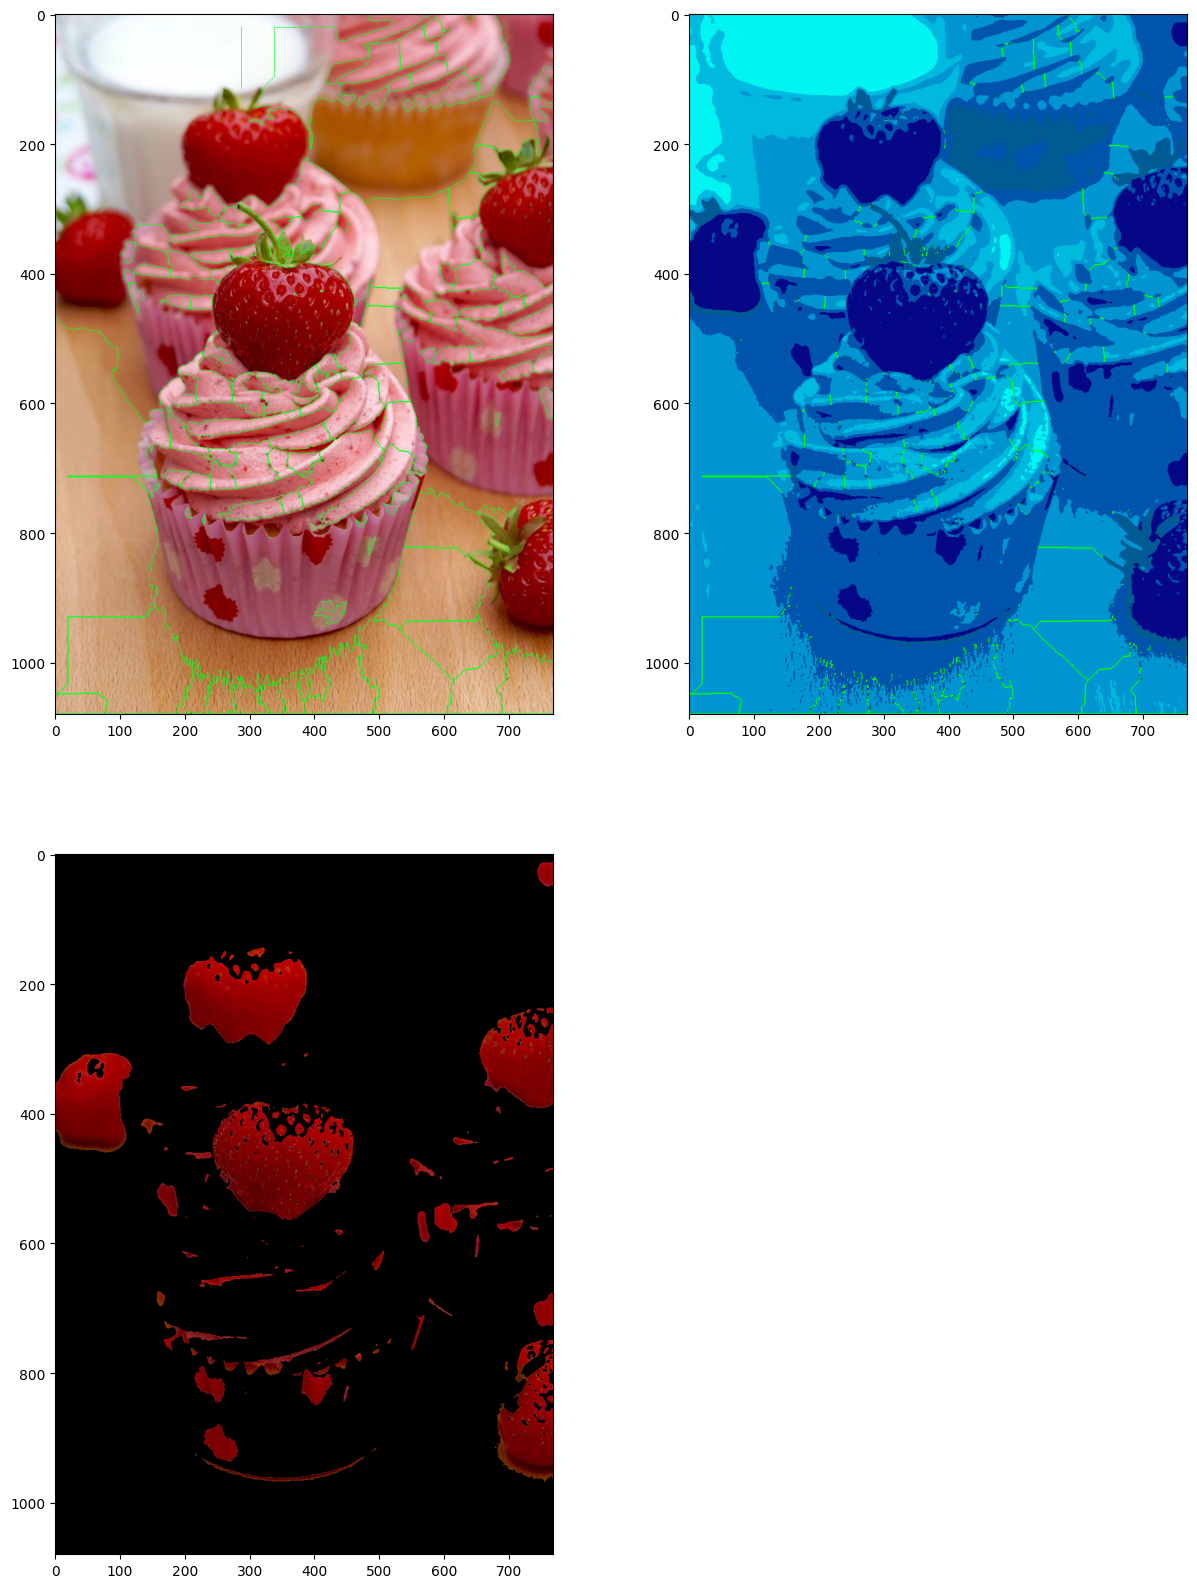

In [44]:
## Методы кластеризации. Сдвиг среднего (Mean shift)
# Сглаживаем чтобы уменьшить шум
blur_image = cv.medianBlur(image, 3)
# Выстраиваем пиксели в один ряд и переводим в формат с правающей точкой
flat_image = np.float32(blur_image.reshape((-1,3)))

# Используем meanshift из библиотеки sklearn
bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labeled = ms.labels_

# получим количество сегментов
segments = np.unique(labeled)
print('Number of segments: ', segments.shape[0])

# получим средний цвет сегмента
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)
# Для каждого пискеля проставим средний цвет его сегмента
mean_shift_image = avg[labeled].reshape((image.shape))
# Маской скроем один из сегментов
mask1 = mean_shift_image[:,:,0]
mask1[mask1!=5] = 0
mean_shift_with_mask_image = cv.bitwise_and(image, image, mask=mask1)
# Построим изображение
gs = plt.GridSpec(2, 2)
plt.figure(figsize=(15,20))
plt.subplot(gs[0])
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.subplot(gs[1])
plt.imshow(mean_shift_image, cmap='Set3')
plt.subplot(gs[2])
plt.imshow(cv.cvtColor(mean_shift_with_mask_image, cv.COLOR_BGR2RGB))
plt.show()

Разрастание областей

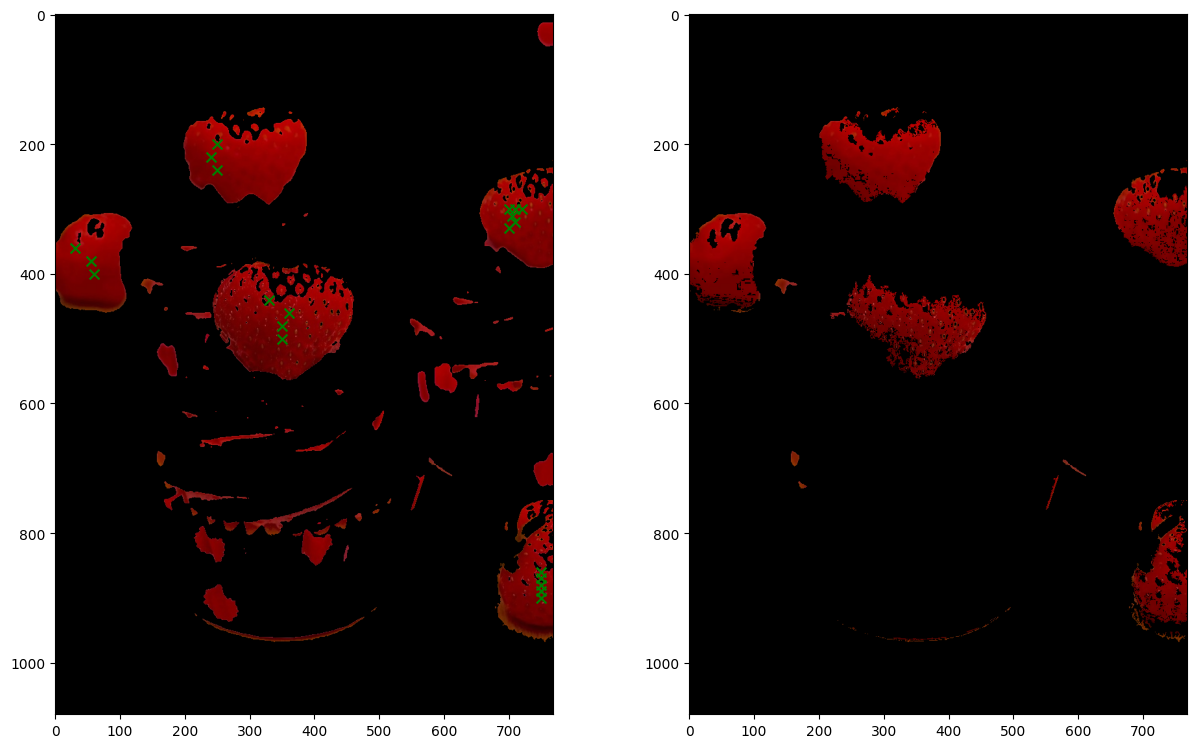

In [45]:
# определяем координаты начальных точек
seeds = [
        (380, 55), (360, 30), (400, 60),
        (200, 250), (220, 240), (240, 250),
        (500, 350), (480, 350), (460, 360), (440, 330),
        (300, 700), (310, 705), (320, 710), (330, 700), (300, 710), (300, 720),
        (900, 750), (890, 750), (880, 750), (870, 750), (860, 750)
    ]
# координаты для графика
x = list(map(lambda x: x[1], seeds))
y = list(map(lambda x: x[0], seeds))
# порог похожести цвета региона
threshold = 100
# находим сегментацию используя метод из segmentation_utils
segmented_region = segmentation_utils.region_growingHSV(image_hsv, seeds, threshold)
# накладываем маску - отображаем только участки попавшие в какой-либо сегмент
result = cv.bitwise_and(mean_shift_with_mask_image, mean_shift_with_mask_image, mask=segmented_region)
# отображаем полученное изображение
gs = plt.GridSpec(2, 2)
plt.figure(figsize=(15,20))
plt.subplot(gs[0])
plt.scatter(x, y, marker="x", color="green", s=50)
plt.imshow(cv.cvtColor(mean_shift_with_mask_image, cv.COLOR_BGR2RGB))
plt.subplot(gs[1])
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()